In [1]:
!pip install gluoncv

    100% |████████████████████████████████| 512kB 29.3MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 30.8MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import mxnet as mx
import numpy as np
import gluoncv as gcv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from mxnet import nd, image
from mxnet.gluon.data.vision import transforms
from gluoncv.model_zoo import get_model
from gluoncv.utils import viz, download

In [4]:
plt.rcParams['figure.figsize'] = (15, 9)

# Image Classification

With this one-line code, we can load a pre-trained **ResNet50_v1** model for classification.

In [3]:
ctx = mx.gpu(0)
#ctx = mx.cpu(0)
net = gcv.model_zoo.resnet50_v1b(pretrained=True, ctx=ctx)

Model file is not found. Downloading.


100%|██████████| 55344/55344 [00:03<00:00, 14269.16KB/s]


With another one-line code we can have our prediction.

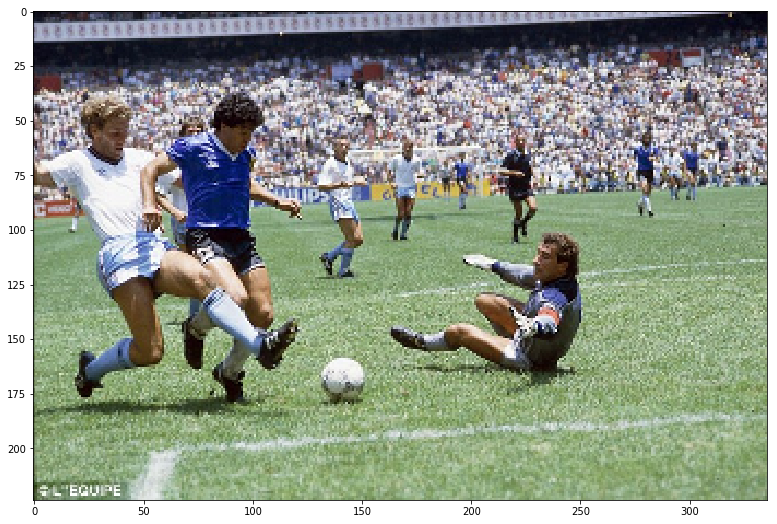

In [5]:
x, img = gcv.data.transforms.presets.ssd.load_test('support/goal.jpg', short=224)
viz.plot_image(img)

In [6]:
%%time
pred = net(x.as_in_context(ctx))

CPU times: user 30.6 ms, sys: 1.03 ms, total: 31.6 ms
Wall time: 62 ms


Let's review the top 5 prediction results.

In [7]:
classes_fname = download('https://raw.githubusercontent.com/hetong007/gluon-cv/master/scripts/classification/imagenet/imagenet_labels.txt',
                         'imagenet_labels.txt')
with open('imagenet_labels.txt', 'r') as f:
    class_names = [l.strip('\n') for l in f.readlines()]

In [9]:
topK = 5
ind = pred.topk(k=topK).astype('int')[0]
for i in range(topK):
    print('[%s], with probability %.1f%%'%
         (class_names[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()*100))

[soccer_ball], with probability 47.5%
[rugby_ball], with probability 22.9%
[football_helmet], with probability 6.2%
[ballplayer], with probability 1.7%
[baseball], with probability 1.1%


# Object Detection

Image classifications are trained to recognize the main object in the scene. What if we have multiple subjects?

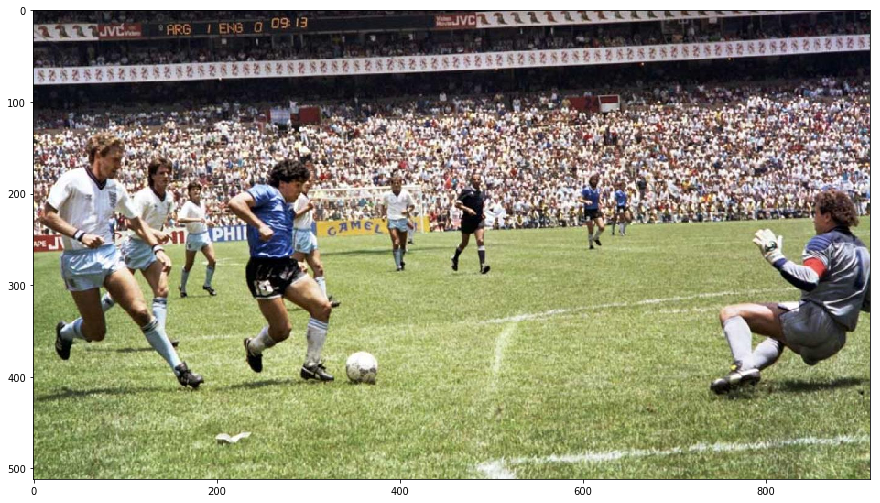

In [10]:
x, img = gcv.data.transforms.presets.ssd.load_test('support/diego.jpg', short=512)
viz.plot_image(img)
plt.show()

We can instead predict with an object detection model **SSD**.
![](support/ssd.png)
![](https://i.stack.imgur.com/Z3cIS.png)

In [12]:
ctx = mx.gpu(0)
#ctx = mx.cpu(1)
net = get_model('ssd_512_resnet50_v1_coco', pretrained=True, ctx=ctx)

Now we predict. Notice we have three output variables.

In [13]:
%%time
class_IDs, scores, bounding_boxes = net(x.as_in_context(ctx))

CPU times: user 40.2 ms, sys: 15.1 ms, total: 55.3 ms
Wall time: 76.6 ms


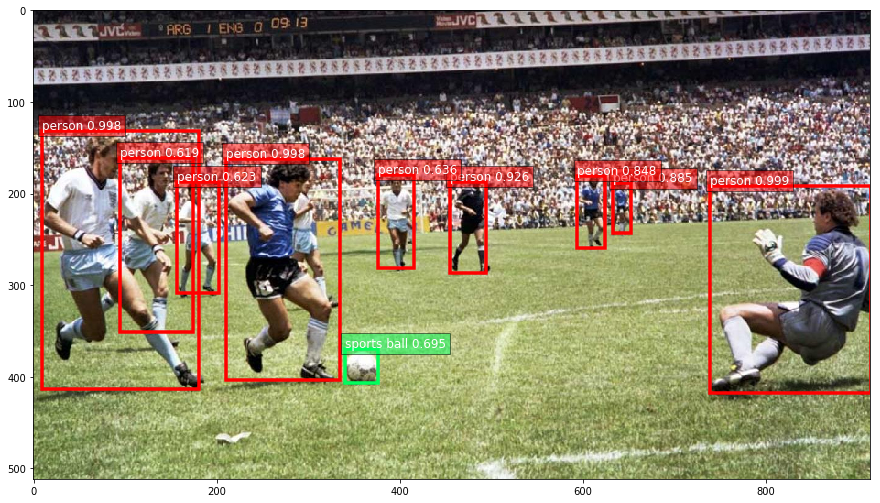

In [14]:
viz.plot_bbox(img, bounding_boxes[0], scores[0], class_IDs[0], class_names=net.classes)
plt.show()

How about we count how many people are here today?

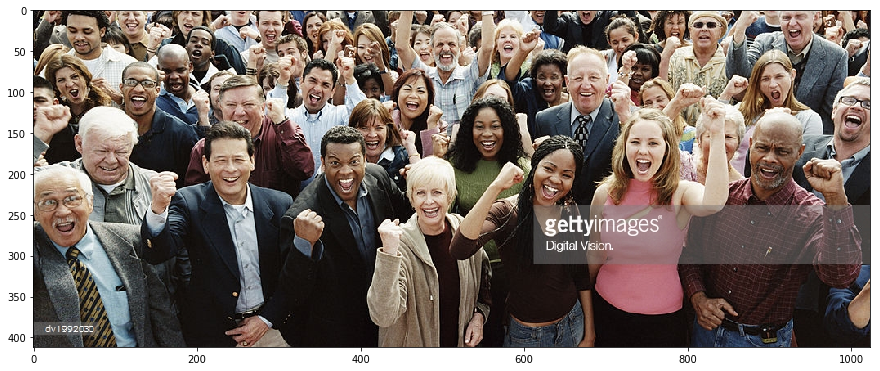

In [15]:
x, img = gcv.data.transforms.presets.ssd.load_test('support/crowd.jpg', short=512)
viz.plot_image(img)
plt.show()

In [16]:
class_IDs, scores, bounding_boxes = net(x.as_in_context(mx.gpu(0)))
#class_IDs, scores, bounding_boxes = net(x.as_in_context(mx.cpu(1)))
person_ind = [i for i, cls in enumerate(net.classes) if cls == 'person']
ind = np.nonzero(class_IDs[0].asnumpy() == person_ind)[0]

new_class_IDs = class_IDs[0][ind]
new_scores = scores[0][ind]
new_bounding_boxes = bounding_boxes[0][ind]

viz.plot_bbox(img, new_bounding_boxes, new_scores, new_class_IDs, class_names=net.classes)

print('There are %d people in this photo.'%(len(ind)))

MXNetError: [03:59:43] src/imperative/cached_op.cc:916: Check failed: inputs[i]->ctx() == default_ctx (gpu(0) vs. cpu(1)) : CachedOp requires all inputs to live on the same context. But data is on cpu(1) while ssd1_resnetv10_conv0_weight is on gpu(0)
Stack trace:
  [bt] (0) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x4a3b8b) [0x7fcbe84fab8b]
  [bt] (1) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(mxnet::CachedOp::Forward(std::shared_ptr<mxnet::CachedOp> const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&)+0x4f8) [0x7fcbea737d68]
  [bt] (2) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(MXInvokeCachedOp+0x4ab) [0x7fcbea652efb]
  [bt] (3) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(MXInvokeCachedOpEx+0x4f) [0x7fcbea6535ff]
  [bt] (4) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7fcc440a0ec0]
  [bt] (5) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7fcc440a087d]
  [bt] (6) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7fcc442b5e2e]
  [bt] (7) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x12865) [0x7fcc442b6865]
  [bt] (8) /home/ec2-user/anaconda3/envs/mxnet_p36/bin/python(_PyObject_FastCallDict+0x8b) [0x559033667d7b]



Another scenario, following the heating topic: automated driving.

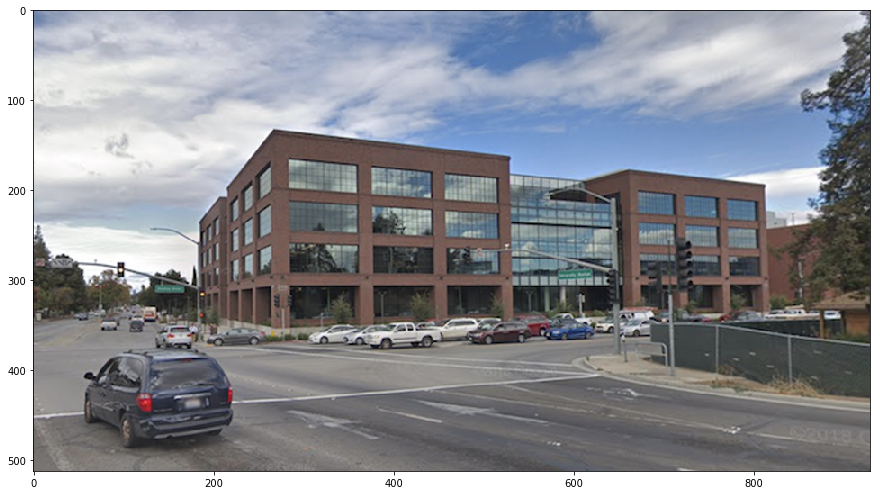

In [24]:
x, img = gcv.data.transforms.presets.ssd.load_test('support/streetview_amazon.png', short=512)
viz.plot_image(img)
plt.show()

In [25]:
%%time
class_IDs, scores, bounding_boxs = net(x.as_in_context(ctx))

CPU times: user 136 ms, sys: 73.1 ms, total: 209 ms
Wall time: 71.2 ms


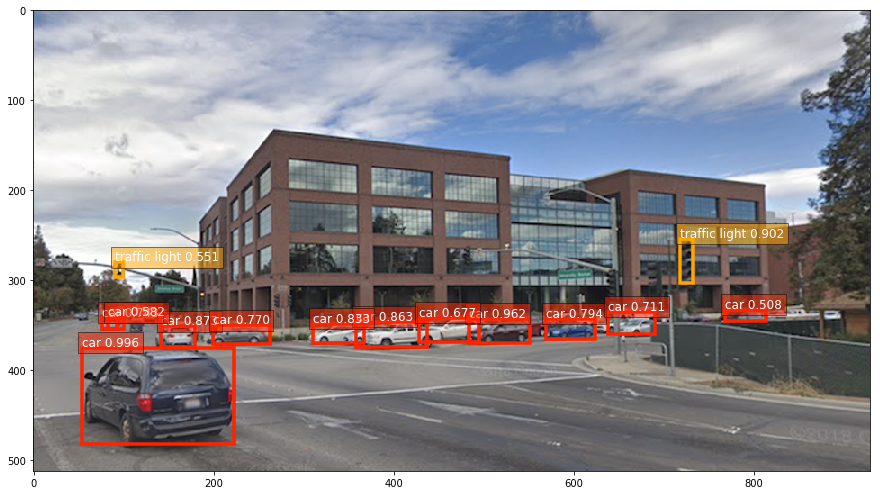

In [26]:
viz.plot_bbox(img, bounding_boxs[0], scores[0], class_IDs[0], class_names=net.classes)
plt.show()

# Semantic Segmentation

Semantic segmentation takes the concept further, by predicting the class for every pixel.

In [27]:
#ctx = mx.gpu(2)
ctx = mx.cpu(2)
net = get_model('fcn_resnet50_ade', pretrained=True, ctx=ctx)

Model file is not found. Downloading.


57418KB [00:03, 15937.69KB/s]                           


Model file is not found. Downloading.


128832KB [00:06, 20348.21KB/s]                            


In [ ]:
%%time
output = net.demo(x.as_in_context(ctx))
pred = output.argmax(1).asnumpy().squeeze()

In [ ]:
mask = viz.get_color_pallete(pred, 'ade20k')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+img)/2

plt.imshow(combined.astype(np.uint8))
plt.show()

In [ ]:
x, img = gcv.data.transforms.presets.ssd.load_test('support/road2.jpg', short=512)
viz.plot_image(img)
plt.show()

In [ ]:
%%time
output = net.demo(x.as_in_context(ctx))
pred = output.argmax(1).asnumpy().squeeze()

In [ ]:
mask = viz.get_color_pallete(pred, 'ade20k')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+img)/2
plt.imshow(combined.astype(np.uint8))
plt.show()